# Kaggle Competition - Optiver - Trading at the Close
<b>Predict US stocks closing movements</b><br>

<b>Description: - </b><br>
The detailed description is available at the competition website https://www.kaggle.com/competitions/optiver-trading-at-the-close.<br>
Here is an extract that effectively summarizes the goal of this competition: -<br>
<i>"In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks<br> using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and<br> demand dynamics, and identify trading opportunities."</i><br>
<br>
<b>Dataset Description: - </b><br>
The dataset description is also available in the competition website at the following link: -<br>
https://www.kaggle.com/competitions/optiver-trading-at-the-close/data<br>

In [2]:
import pandas as pd

import os
import numpy as np
import math
from matplotlib import pyplot as plt
import time

from scipy.stats import norm, levene, f_oneway, zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.metrics import r2_score

import warnings
import json

from torch import nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch

import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.manual_seed(42)

In [4]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [5]:
dataset_df = pd.read_csv('train.csv')

In [6]:
#Changing datatypes to reduce memory consumption.
dataset_df['stock_id'] = dataset_df['stock_id'].astype('int16')
dataset_df['date_id'] = dataset_df['date_id'].astype('int16')
dataset_df['seconds_in_bucket'] = dataset_df['seconds_in_bucket'].astype('int16')
dataset_df['imbalance_buy_sell_flag'] = dataset_df['imbalance_buy_sell_flag'].astype('int8')
dataset_df['time_id'] = dataset_df['time_id'].astype('int16')
dataset_df['target'] = dataset_df['target'].astype('float32')

# 1) View summary of the data

In [8]:
print(f'Shape of the training data = ', dataset_df.shape)

Shape of the training data =  (5237980, 17)


In [9]:
print('First 5 rows: -')
dataset_df.head()

First 5 rows: -


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010201,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [10]:
print('Description of the data: -')
dataset_df.describe()

Description of the data: -


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756123e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.413762e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


# 2) Handling missing values

## 2.1) Determine missingness in the dataframe

### 2.1.1) Determine the percentage of missing values for each column in the dataframe<br>

As can be seen below, there are non-zero missing value percentages for the following fields: -
1) imbalance_size
2) reference_price
3) matched_size
4) bid_price
5) ask_price
6) wap
7) target

In [14]:
#Displaying missing values.
print("List of missing values for various columns of the dataframe: -")
num_missing_vals_series = (dataset_df.isnull().sum(axis = 0)/dataset_df.shape[0]) * 100
num_missing_vals_series

List of missing values for various columns of the dataframe: -


stock_id                    0.000000
date_id                     0.000000
seconds_in_bucket           0.000000
imbalance_size              0.004200
imbalance_buy_sell_flag     0.000000
reference_price             0.004200
matched_size                0.004200
far_price                  55.256836
near_price                 54.547364
bid_price                   0.004200
bid_size                    0.000000
ask_price                   0.004200
ask_size                    0.000000
wap                         0.004200
target                      0.001680
time_id                     0.000000
row_id                      0.000000
dtype: float64

<b>Corrective Actions:</b>
1) Rows with missing values for the above columns have NOT been removed.
2) Missing values for 'target' have been filled-in with zeros.

In [16]:
dataset_df['target'] = dataset_df['target'].fillna(0)

## 2.2) Determine gaps in date and time ID values

### 2.2.1) Determine stock IDs that have gaps in date IDs<br>

In [19]:
stock_id_miss_date_ids = {}

#Go through each of the 200 stock IDs.
for stock_id in range(0, 200):
    
    dataset_sid_df = dataset_df[dataset_df['stock_id'] == stock_id].copy()

    #Compute the expected number of date IDs based on the minimum and maximum date ID value.
    min_date_id = dataset_sid_df['date_id'].min()
    max_date_id = dataset_sid_df['date_id'].max()
    est_date_ids = max_date_id - min_date_id + 1

    #Determine the actual number of date ID values.
    act_date_ids = len(list(dataset_sid_df['date_id'].unique()))

    #If the expected and the actual number of date ID values do not match, this stock ID has missing date IDs.
    if est_date_ids !=  act_date_ids:
        stock_id_miss_date_ids[stock_id] = []

        for date_id in range(min_date_id, max_date_id + 1):
            if date_id not in list(dataset_sid_df['date_id'].unique()):
                stock_id_miss_date_ids[stock_id] = stock_id_miss_date_ids[stock_id] + [date_id]

print('Stock IDs and the dates for which data is missing: -')

for stock_id in stock_id_miss_date_ids.keys():
    print(f'Stock ID = {stock_id}, Date IDs = {stock_id_miss_date_ids[stock_id]}')

Stock IDs and the dates for which data is missing: -
Stock ID = 73, Date IDs = [320]
Stock ID = 99, Date IDs = [138]


### 2.2.2) Determine stock IDs that have gaps in time IDs<br>

In [21]:
#Go through each stock ID.
for stock_id in range(0, 200):
    
    dataset_sid_df = dataset_df[dataset_df['stock_id'] == stock_id].copy()
    
    #Determine the expected number of time IDs based on the minimum and maximum time ID value.
    min_time_id = dataset_sid_df['time_id'].min()
    max_time_id = dataset_sid_df['time_id'].max()
    est_num_time_ids = max_time_id - min_time_id + 1
    
    #Determine the actual number of time IDs.
    act_num_time_ids = len(list(dataset_sid_df['time_id']))

    #If the expected and the actual number of time ID values do not match, this stock ID has missing time IDs.
    if est_num_time_ids !=  act_num_time_ids:
        print(f'Stock ID {stock_id} has {est_num_time_ids - act_num_time_ids} time IDs')

Stock ID 73 has 55 time IDs
Stock ID 99 has 55 time IDs


The number of missing time IDs (55 each) for stock IDs 73 and 99 is consistent with the number of date IDs (1 each) that are missing for stock IDs 73 and 99.

### 2.2.3) Impute the missing

1) Imputing records for date ID 320 for stock ID 73
   - Retreive records associated with the previous date ID i.e., 319.
   - Change the date and time IDs in those records.
   - Insert them back into the dataframe.

In [25]:
#Retreive records associated with stock ID 73 and date ID 319 (for which records do exist).
records_to_replicate = dataset_df[(dataset_df['stock_id'] == 73) & (dataset_df['date_id'] == 319)].copy()
#Determine the highest time ID value associated with stock ID 73 for date ID 319.
high_prev_time_id = records_to_replicate[records_to_replicate['seconds_in_bucket'] == 540]['time_id'].iloc[0]

#Generate new time ID values for the records to be inserted for date ID 320.
new_time_ids = sorted([time_id for time_id in range(high_prev_time_id+1, high_prev_time_id+56)])
#Update the 'date_id' and 'time_id' columns in the records.
records_to_replicate['date_id'] = 320
records_to_replicate['time_id'] = new_time_ids

#Add the records back to the dataframe.
dataset_df = pd.concat([dataset_df, records_to_replicate], ignore_index=True)
dataset_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010201,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


2) Imputing records for date ID 138 for stock ID 99.
   - Retreive records associated with the previous date ID i.e., 137.
   - Change the date and time IDs in those records.
   - Insert them back into the dataframe.

In [27]:
#Retreive records associated with stock ID 99 and date ID 137 (for which records do exist).
records_to_replicate = dataset_df[(dataset_df['stock_id'] == 99) & (dataset_df['date_id'] == 137)].copy()
#Determine the highest time ID value associated with stock ID 99 for date ID 137.
high_prev_time_id = records_to_replicate[records_to_replicate['seconds_in_bucket'] == 540]['time_id'].iloc[0]

#Generate new time ID values for the records to be inserted for date ID 138.
new_time_ids = sorted([time_id for time_id in range(high_prev_time_id+1, high_prev_time_id+56)])
#Update the 'date_id' and 'time_id' columns in the records.
records_to_replicate['date_id'] = 138
records_to_replicate['time_id'] = new_time_ids

#Add the records back to the dataframe.
dataset_df = pd.concat([dataset_df, records_to_replicate], ignore_index=True)
dataset_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010201,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


3) Check again for stock IDs with missing date IDs and time IDs

In [29]:
#Check if missing date IDs still exist.
stock_id_miss_date_ids = {}

for stock_id in range(0, 200):
    
    dataset_sid_df = dataset_df[dataset_df['stock_id'] == stock_id].copy()
    min_date_id = dataset_sid_df['date_id'].min()
    max_date_id = dataset_sid_df['date_id'].max()
    est_date_ids = max_date_id - min_date_id + 1
    act_date_ids = len(list(dataset_sid_df['date_id'].unique()))
    
    if est_date_ids !=  act_date_ids:
        print(f'{stock_id} has {est_date_ids - act_date_ids} missing date IDs')
        stock_id_miss_date_ids[stock_id] = []

        for date_id in range(min_date_id, max_date_id + 1):
            if date_id not in list(dataset_sid_df['date_id'].unique()):
                stock_id_miss_date_ids[stock_id] = stock_id_miss_date_ids[stock_id] + [date_id]

print('Stock IDs and the dates for which data is missing: -')
print(stock_id_miss_date_ids)

Stock IDs and the dates for which data is missing: -
{}


In [30]:
#Check if missing time IDs still exist.
for stock_id in range(0, 200):
    dataset_sid_df = dataset_df[dataset_df['stock_id'] == stock_id].copy()
    min_time_id = dataset_sid_df['time_id'].min()
    max_time_id = dataset_sid_df['time_id'].max()
    est_num_time_ids = max_time_id - min_time_id + 1
    act_num_time_ids = len(list(dataset_sid_df['time_id']))
    if est_num_time_ids !=  act_num_time_ids:
        print(f'{stock_id} has {est_num_time_ids - act_num_time_ids} time IDs')

In [31]:
dataset_df.set_index('time_id', inplace=True)
dataset_df['time_id'] = dataset_df.index

# 3) Time-series Analysis
- Auto-correlation Function (ACF)<br>
- Partial Auto-Correlation Function (PACF)<br>

## 3.1) Checking for Stationarity
- <b><u>Condition 1</u></b>: - The mean must be constant and not vary with time.
- <b><u>Condition 2</u></b>: - The variance must be constant and not vary with time.
- <b><u>Condition 3</u></b>: - There must be no periodicity in the data.

### 3.1.1) Checking for conditions 1 and 2 - The mean and variance must be constant and not vary with time

#### 1) Doing the ANOVA AND Levene test for each stock ID to determine if the target prices are associated with the same mean.
The samples for the ANOVA and Levene test were created as follows: -<br>
1) The target prices for multiple adjacent time IDs were combined to form a sample using the following window sizes: -<br>
   a) Window size = 3<br>
   b) Window size = 10<br>
   c) Window size = 20<br>
   d) Window size = 55<br>
   e) Window size = 110<br>
   f) Window size = 165<br>
   g) Window size = 220<br>
   h) Window size = 275<br>
   
2) When the window size = 3, the window starts at the first date.<br>
   The target prices for the 3 adjacent dates starting at the first date then constitute a single sample. The window then moves by a step of size 3.<br>
   The target prices for the 3 adjacent dates starting at the current window position then constitute the second sample. The window then moves by a step of size 3.<br>
   And so on....

3) The samples for window sizes of 10, 20, 55, 110, 165, 220 and 275 are similarly built.

In [36]:
SIG_LEVEL = 0.01

In [37]:
#{stock_id: window_size}
stock_id_auto_corr_dict = {}

In [38]:
def do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 3, col = 'target', verbose = False):

    #Get the current stock ID.
    stock_id = stock_id_dataset_df['stock_id'].unique()[0]

    #
    if stock_id in stock_id_auto_corr_dict.keys():
        return stock_id_auto_corr_dict

    #
    if verbose == True:
        print(f'Window size = {window_size}')
    
    sample_list = []

    #Determine the smallest and largest time IDs associated with the stock.
    unique_time_id_list = stock_id_dataset_df['time_id'].unique()
    start_time_id = min(unique_time_id_list)
    end_time_id = max(unique_time_id_list) - window_size + 1

    #Step size will be equal to the window size so that the windows are NOT overlapping.
    step_size = window_size

    #Construct windows and add to the sample_list.
    for time_id in range(start_time_id, end_time_id, step_size):
        curr_wind_target_array = np.array(stock_id_dataset_df[(stock_id_dataset_df['time_id'] >= time_id) & (stock_id_dataset_df['time_id'] <= time_id+step_size-1)][col])
        
        if curr_wind_target_array.shape[0] > 0:
            sample_list.append(curr_wind_target_array)
    
    try:
        #Perform one-way ANOVA for the current stock ID using the samples associated with the current stock ID.
        anova_result = f_oneway(*sample_list)
    
    except Exception as err:
        print(err)
        return

    #The null hypothesis that the samples of targets have the same mean cannot be rejected.
    if anova_result.pvalue > SIG_LEVEL:

        #Do the levene test.
        _, p_val = levene(*sample_list)

        #The null hypothesis that the samples of targets have the same variances cannot be rejected.
        if p_val > SIG_LEVEL:
            stock_id_auto_corr_dict[stock_id] = window_size
            print(f'For stock ID {stock_id}, window size {window_size}, the target prices have a mean and variance that remains constant with time.')

In [39]:
verbose = False

#Loop through all the stock IDs.
for stock_id in range(0, 200):

    #Determine the data associated with the current stock ID.
    stock_id_dataset_df = dataset_df[dataset_df['stock_id'] == stock_id]
    
    if verbose == True:
        print(f'\nStart of ANOVA for stock ID {stock_id}, {stock_id_dataset_df.shape[0]} prices')

    #Do the ANOVA and the Levene test for varying window sizes.
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 3, verbose = verbose)   #3 successive targets
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 10, verbose = verbose)  #10 successive targets
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 20, verbose = verbose)  #20 successive targets
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 55, verbose = verbose)  #55 successive targets (corressponding to one day)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 110, verbose = verbose) #110 successive targets (corressponding to two days)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 165, verbose = verbose) #165 successive targets (corressponding to three days)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 220, verbose = verbose) #220 successive targets (corressponding to four days)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 275, verbose = verbose) #275 successive targets (corressponding to five days)
    
    if verbose == True:
        if stock_id not in stock_id_auto_corr_dict.keys():
            print(f'For stock ID {stock_id}, the target prices do NOT have a mean and variance that remains constant with time for any of the window sizes.')
        
        print(f'End of ANOVA for stock ID {stock_id}\n')

In [40]:
print(f'Number of stock IDs with a constant mean and variance = {len(stock_id_auto_corr_dict.keys())}')
if len(stock_id_auto_corr_dict.keys()) > 0:
    print('Stock IDs and their respective means: -')
    for stock_id in stock_id_auto_corr_dict:
        print(f'Stock ID = {stock_id}, window size = {stock_id_auto_corr_dict[stock_id]}')

Number of stock IDs with a constant mean and variance = 0


<b>Conclusion</b>: -<br>
It was found that the none of the stock IDs had a constant mean and variance across all the samples for any of the window sizes.<br>
The data, in its existing form, therefore, is not stationary.

#### 2) Winsoring outliers and repeating the ANOVA AND Levene test for each stock ID to determine if the target prices are associated with the same mean.

##### When plotting target vs time ID for stock IDs 1 and 10, it can be seen that there are considerable number of extreme values. These extreme values might be contributing to the lack of stationarity in the data.

Plot of target values for stock ID 1


Text(0.5, 1.0, 'Stock ID 1 - Target vs Time ID (Before Windsoring)')

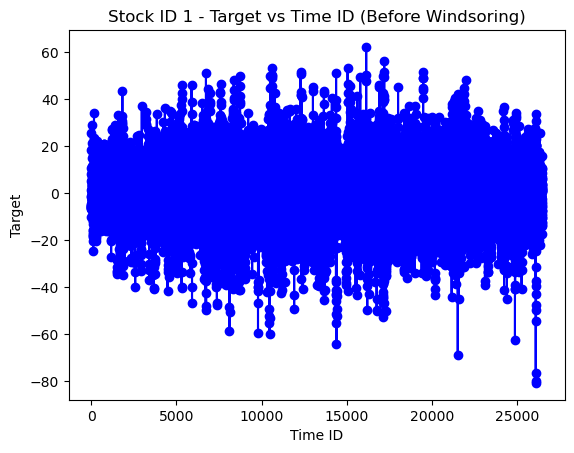

In [44]:
#Plot the target vs Time ID for stock ID 1.
stock_id = 1
print(f'Plot of target values for stock ID {stock_id}')
plt.plot(dataset_df[dataset_df['stock_id'] == stock_id]['time_id'], dataset_df[dataset_df['stock_id'] == stock_id]['target'], marker='o', linestyle='-', color='b')
plt.xlabel('Time ID')
plt.ylabel('Target')
plt.title(f'Stock ID {stock_id} - Target vs Time ID (Before Windsoring)')

Plot of target values for stock ID 10


Text(0.5, 1.0, 'Stock ID 10 - Target vs Time ID (Before Windsoring)')

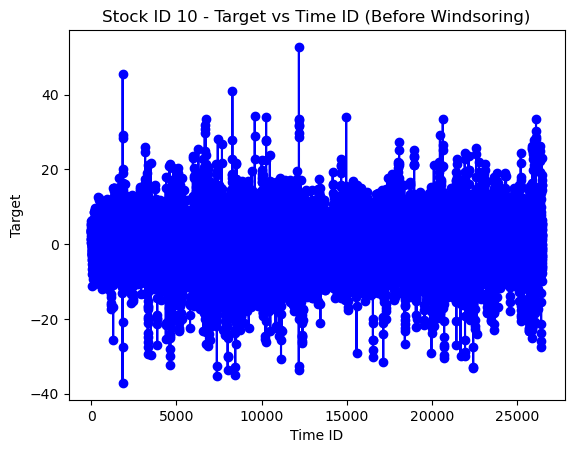

In [45]:
#Plot the target vs Time ID for stock ID 10.
stock_id = 10
print(f'Plot of target values for stock ID {stock_id}')
plt.plot(dataset_df[dataset_df['stock_id'] == stock_id]['time_id'], dataset_df[dataset_df['stock_id'] == stock_id]['target'], marker='o', linestyle='-', color='b')
plt.xlabel('Time ID')
plt.ylabel('Target')
plt.title(f'Stock ID {stock_id} - Target vs Time ID (Before Windsoring)')

##### Winsoring outliers using the IQR-based approaching for identifying ouliers. <br>The idea is to cap the extreme values to make the data stationary.

In [47]:
#Find outliers using the IQR approach.
def replace_iqr_outliers(dataset_stock_id_df):

    #Compute the first and the third quantiles.
    target_q1 = dataset_stock_id_df['target'].quantile(0.25)
    target_q3 = dataset_stock_id_df['target'].quantile(0.75)

    #Compute the IQR.
    iqr = target_q3 - target_q1

    #Compute the lower and upper bounds (beyond which anything would be considered an outlier).
    lower_bound = target_q1 - 1.5 * iqr
    upper_bound = target_q3 + 1.5 * iqr

    #Replace all targets that are lower than the lower bound with the lower bound.
    dataset_stock_id_df['target'] = np.where(dataset_stock_id_df['target'] < lower_bound, lower_bound, dataset_stock_id_df['target'])

    #Replace all targets that are higher than the upper bound with the upper bound.
    dataset_stock_id_df['target'] = np.where(dataset_stock_id_df['target'] > upper_bound, upper_bound, dataset_stock_id_df['target'])

    return dataset_stock_id_df    

In [48]:
#Apply winsoring to the target values of all stock IDs.
dataset_orig_df = dataset_df.copy()
dataset_df = dataset_df.groupby('stock_id', group_keys=False).apply(replace_iqr_outliers)

##### After winsoring, the plot looks like a trimmed hedge indicating that a large number of extreme target values have been capped.

Plot of target values for stock ID 1


Text(0.5, 1.0, 'Stock ID 1 - Target vs Time ID (After Windsoring)')

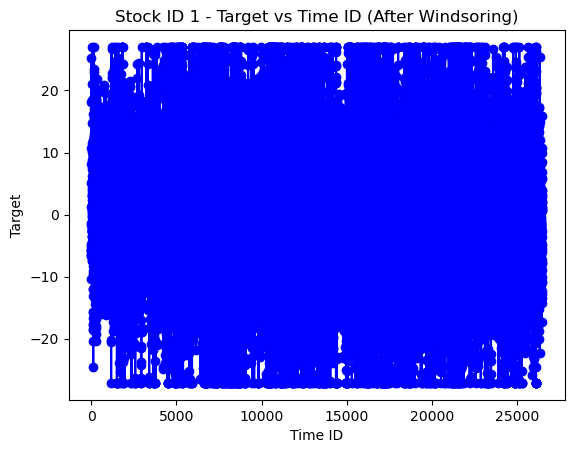

In [50]:
#Plot the target vs Time ID for stock ID 1 after windsoring.
stock_id = 1
print(f'Plot of target values for stock ID {stock_id}')
plt.plot(dataset_df[dataset_df['stock_id'] == stock_id]['time_id'], dataset_df[dataset_df['stock_id'] == stock_id]['target'], marker='o', linestyle='-', color='b')
plt.xlabel('Time ID')
plt.ylabel('Target')
plt.title(f'Stock ID {stock_id} - Target vs Time ID (After Windsoring)')

Plot of target values for stock ID 10


Text(0.5, 1.0, 'Stock ID 10 - Target vs Time ID (After Windsoring)')

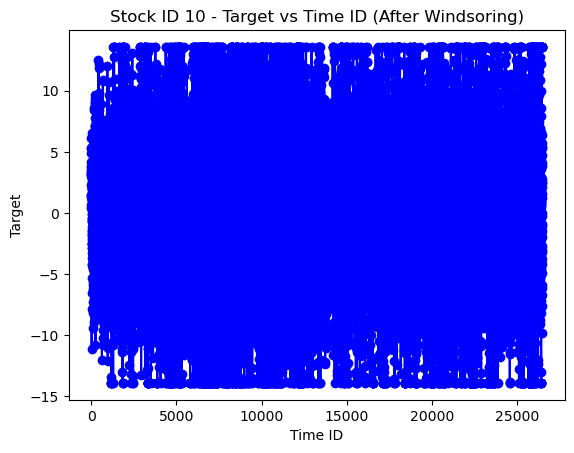

In [51]:
#Plot the target vs Time ID for stock ID 10 after windsoring.
stock_id = 10
print(f'Plot of target values for stock ID {stock_id}')
plt.plot(dataset_df[dataset_df['stock_id'] == stock_id]['time_id'], dataset_df[dataset_df['stock_id'] == stock_id]['target'], marker='o', linestyle='-', color='b')
plt.xlabel('Time ID')
plt.ylabel('Target')
plt.title(f'Stock ID {stock_id} - Target vs Time ID (After Windsoring)')

In [52]:
verbose = False
stock_id_auto_corr_dict = {}
for stock_id in range(0, 200):
    
    stock_id_dataset_df = dataset_df[dataset_df['stock_id'] == stock_id]
    
    if verbose == True:
        print(f'\nStart of ANOVA for stock ID {stock_id}, {stock_id_dataset_df.shape[0]} prices')

    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 3)   #3 successive targets
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 10)  #10 successive targets
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 20)  #20 successive targets
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 55)  #55 successive targets (corressponding to one day)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 110) #110 successive targets (corressponding to two days)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 165) #165 successive targets (corressponding to three days)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 220) #220 successive targets (corressponding to four days)
    do_anova_levene_test(stock_id_auto_corr_dict, stock_id_dataset_df, window_size = 275) #275 successive targets (corressponding to five days)

    if verbose == True:
        if stock_id not in stock_id_auto_corr_dict.keys():
            print(f'For stock ID {stock_id}, the target prices do NOT have a mean and variance that remains constant with time for any of the window sizes.')

    if verbose == True:
        print(f'End of ANOVA for stock ID {stock_id}\n')

In [53]:
print(f'Number of stock IDs with a constant mean and variance = {len(stock_id_auto_corr_dict.keys())}')
if len(stock_id_auto_corr_dict.keys()) > 0:
    print('Stock IDs and their respective means: -')
    for stock_id in stock_id_auto_corr_dict:
        print(f'Stock ID = {stock_id}, window size = {stock_id_auto_corr_dict[stock_id]}')

Number of stock IDs with a constant mean and variance = 0


In [54]:
#Restoring the unwindsored data.
dataset_df = dataset_orig_df

<b>Conclusion</b>: -<br>
It was found that despite Windsoring, none of the stock IDs had a constant mean and variance across all the samples for any of the window sizes.

### 3.1.2) Checking for condition 3 - There must be no seasonality in the data.
Since conditions 1) and 2) have not been met, we already know that the data is not stationary and condition 3, therefore, is not required to be checked for the purpose of determining stationarity.<br>
However, looking at plots of ACF and PACF might reveal some insights about the relationship of the target with the lag values.

1) Visual inspection of <b>ACF plots</b> and <b>PACF plots</b>: -

In [58]:
NUM_LAGS = 110

In [59]:
stock_id = 6
#stock_id = 10
#stock_id = 100
#stock_id = 199

Visual inspection of ACF plot for stock ID 6: -


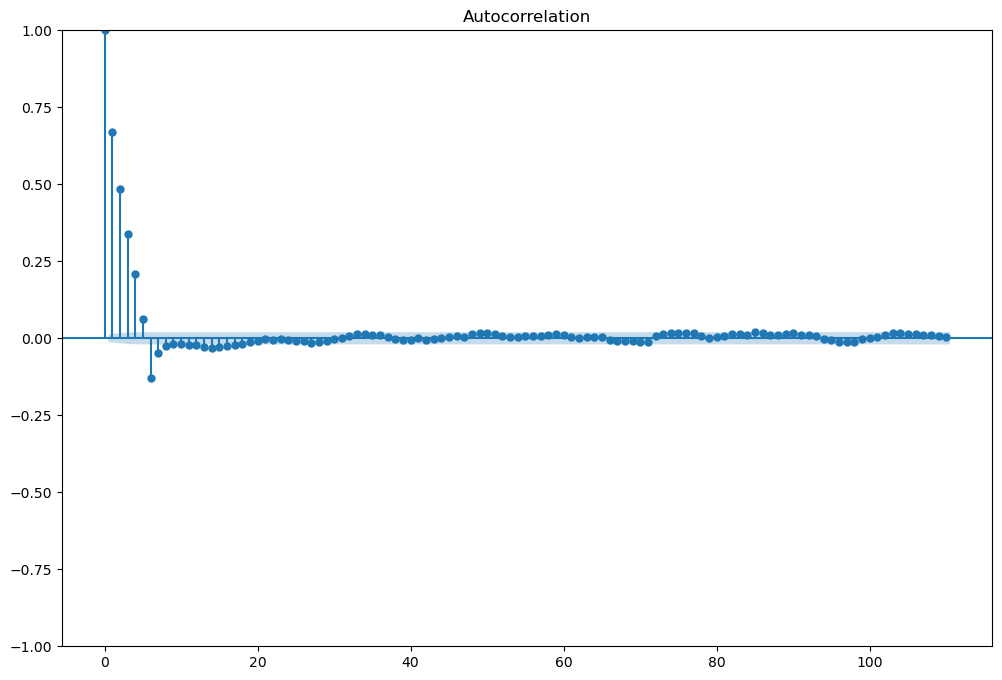

In [60]:
print(f'Visual inspection of ACF plot for stock ID {stock_id}: -')
#Creating the ACF plot for target prices for stock ID 1.
fig, ax = plt.subplots(figsize=(12, 8))
target_vals = dataset_df[(dataset_df['stock_id'] == stock_id)]['target']
acf_plot = plot_acf(target_vals, lags=NUM_LAGS, ax=ax)

Visual inspection of PACF plot for stock ID 6: -


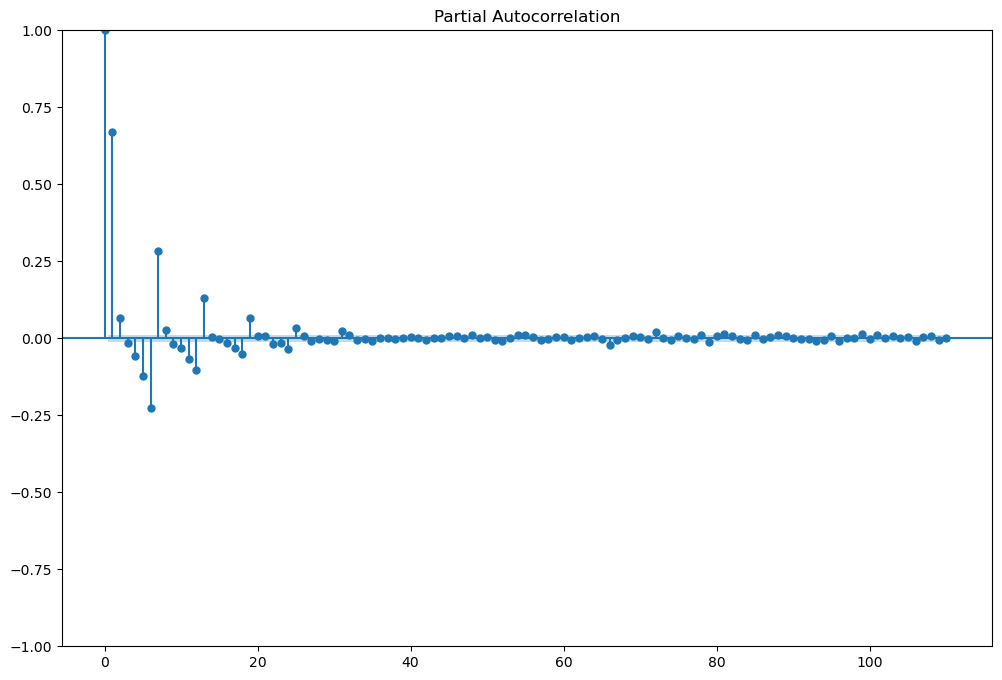

In [61]:
print(f'Visual inspection of PACF plot for stock ID {stock_id}: -')
#Creating the PACF plot for target prices for stock ID 1.
fig, ax = plt.subplots(figsize=(12, 8))
target_vals = dataset_df[(dataset_df['stock_id'] == stock_id)]['target']
acf_plot = plot_pacf(target_vals, lags=NUM_LAGS, ax=ax)

<b>Observation</b>: -<br>
The visual inspection of the ACF plots for various stock IDs reveals a great degree of similarity in pattern.

The visual inspection of the PACF plots for various stock IDs also reveals a great degree of similarity in pattern.

<b>Approach going ahead</b>: -<br>
The approach ahead is based on the following understanding of ACF and PACF: -
1) The ACF represents the (direct + indirect) correlation of a lag with the target.<br>
2) The PACF represents the direct correlation of a lag with the target.<br>

<b>Approach:-</b>
1) For a given lag, compute the difference between the ACF correlation and PACF correlation. This will give us the indirect correlation of the lag.
2) Where the direct correlation >= 0.20.
3) Where the indirect correlation >= 0.20.
4) Where the indirect as well as direct correlation < 0.20, ignore those lags.<br>

Using the above approach, let's determine the list of lags that have direct correlation and those that have indirect correlation. We will look as far back as 50 lags.

In [64]:
dir_corr_dict = {}
indir_corr_dict = {}
NUM_LAGS = 50
CORR_THRESHOLD = 0.20

In [65]:
#Go through all the stock IDs.
for stock_id in range(0, 200):

    #For the current stock ID, maintain list of lag values with high direct and indirect correlation respectively.
    dir_corr_dict[stock_id] = []
    indir_corr_dict[stock_id] = []
    
    stock_id_dataset_df = dataset_df[dataset_df['stock_id'] == stock_id]

    #Determine the ACF and partial ACF values for the target for all lags up to NUM_LAGS.
    acf_values = acf(stock_id_dataset_df['target'], nlags=NUM_LAGS)
    pacf_values = pacf(stock_id_dataset_df['target'], nlags=NUM_LAGS)

    #Go through all lags from 1 to NUM_LAG.
    for lag_no in range(1, NUM_LAGS+1):
        
        #Maintain list of lag values that have high direct correlation.
        if ((pacf_values[lag_no] >= CORR_THRESHOLD) or (pacf_values[lag_no] <= -CORR_THRESHOLD)):
            dir_corr_dict[stock_id].append(lag_no)

        #Compute indirect correlation for the current lag.
        indir_corr = acf_values[lag_no] - pacf_values[lag_no]
        
        #Maintain list of lag values that have high indirect correlation.
        if ((indir_corr >= CORR_THRESHOLD) or (indir_corr <= -CORR_THRESHOLD)):
            indir_corr_dict[stock_id].append(lag_no)

In [66]:
print('Direct lag values for stock IDs: -')
for stock_id in dir_corr_dict.keys():
    print(f'Stock ID {stock_id}, Lag values: - {dir_corr_dict[stock_id]}')

Direct lag values for stock IDs: -
Stock ID 0, Lag values: - [1, 7]
Stock ID 1, Lag values: - [1, 7]
Stock ID 2, Lag values: - [1, 7]
Stock ID 3, Lag values: - [1, 7]
Stock ID 4, Lag values: - [1, 7]
Stock ID 5, Lag values: - [1, 7]
Stock ID 6, Lag values: - [1, 6, 7]
Stock ID 7, Lag values: - [1, 6, 7]
Stock ID 8, Lag values: - [1, 6, 7]
Stock ID 9, Lag values: - [1, 7]
Stock ID 10, Lag values: - [1, 7]
Stock ID 11, Lag values: - [1, 7]
Stock ID 12, Lag values: - [1, 7]
Stock ID 13, Lag values: - [1, 7]
Stock ID 14, Lag values: - [1, 7]
Stock ID 15, Lag values: - [1, 7]
Stock ID 16, Lag values: - [1, 6, 7]
Stock ID 17, Lag values: - [1, 7]
Stock ID 18, Lag values: - [1, 7]
Stock ID 19, Lag values: - [1, 7]
Stock ID 20, Lag values: - [1, 7]
Stock ID 21, Lag values: - [1, 7]
Stock ID 22, Lag values: - [1, 7]
Stock ID 23, Lag values: - [1, 7]
Stock ID 24, Lag values: - [1, 7]
Stock ID 25, Lag values: - [1, 7]
Stock ID 26, Lag values: - [1, 7]
Stock ID 27, Lag values: - [1, 7]
Stock ID 28

In [67]:
print('Indirect lag values for stock IDs: -')
for stock_id in indir_corr_dict.keys():
    print(f'Stock ID {stock_id}, Lag values: - {indir_corr_dict[stock_id]}')

Indirect lag values for stock IDs: -
Stock ID 0, Lag values: - [2, 3, 4, 5, 7]
Stock ID 1, Lag values: - [2, 3, 4, 7]
Stock ID 2, Lag values: - [2, 3, 4, 7]
Stock ID 3, Lag values: - [2, 3, 4, 5, 7]
Stock ID 4, Lag values: - [2, 3, 4, 5, 7]
Stock ID 5, Lag values: - [2, 3, 4, 7]
Stock ID 6, Lag values: - [2, 3, 4, 7]
Stock ID 7, Lag values: - [2, 3, 4, 7]
Stock ID 8, Lag values: - [2, 3, 4, 7]
Stock ID 9, Lag values: - [2, 3, 4, 5, 7]
Stock ID 10, Lag values: - [2, 3, 4, 5, 7]
Stock ID 11, Lag values: - [2, 3, 4, 5, 7]
Stock ID 12, Lag values: - [2, 3, 4, 5, 7]
Stock ID 13, Lag values: - [2, 3, 4, 5, 7]
Stock ID 14, Lag values: - [2, 3, 4, 5, 7]
Stock ID 15, Lag values: - [2, 3, 4, 5, 7]
Stock ID 16, Lag values: - [2, 3, 4, 7]
Stock ID 17, Lag values: - [2, 3, 4, 5, 7]
Stock ID 18, Lag values: - [2, 3, 4, 5, 7]
Stock ID 19, Lag values: - [2, 3, 4, 5, 7]
Stock ID 20, Lag values: - [2, 3, 4, 5, 7]
Stock ID 21, Lag values: - [2, 3, 4, 5, 7]
Stock ID 22, Lag values: - [2, 3, 4, 5, 7]
Stock

<b>Conclusions</b>: -<br>
The most common set of lag values that have a high direct correlation with the target are 1 and 7.<br>
The most common set of lag values that have a high indirect correlation with the target are 2, 3, 4, 5, and 7.<br>

# 4) RNN-based models - LSTM

## 4.1) Single LSTM model for all stock IDS

This model will be a simple LSTM model and will be employed for predicting the target for all the stock IDs.<br>
1) This model will use only the target lag values and stock IDs to predict the target at the current timestamp. It will not use any other features.<br>
<br>
2) The model will be trained on training data consisting of sequences and labels such as the following: -<br>
   <pre><b>Sequence</b>                                                                             <b>Label (Target at current Time ID)</b>
   Lag 7 Target->Lag 5 Target->Lag 4 target->Lag 3 Target->Lag 2 Target->Lag 1 Target   Predicted Target</pre><br>
   <b><u>Points worth noting</u></b>: -<br>
   - The lag values are with respect to the current time ID.<br>
   - Lags 2, 3, 4, 5, and 7 are part of the above sequence. This enables these lag values to be used to make the prediction for the current time ID.<br>
   - Lag value 1 is at the last time-step of the sequence. This, therefore, enables prediction for the current time ID to be done based directly
     on the lag 1 value which is desirable because of the high correlation.
   - Since we are using an LSTM which has a long-term memory, it is hoped that the LSTM will also capture the direct dependency between the target
     at the current time ID and the target at lag 7. <br>
<br>
3) The stock IDs will be represented as one-hot vectors. This means that the input will have the dimension 201.<br>
   201 features = 1 feature for target value + 1 one-hot feature for the each of the 200 stock IDs.<br>
<br>
4) Based on the above, each sequence will have the following dimension: -<br>
   6 (sequence length) x 201 (Input dimension)



In [71]:
lag_vals_list = [7, 5, 4, 3, 2, 1]
seq_len = len(lag_vals_list)

### 4.1.1) Data transformation

#### 1) Construct training, validation, and testing dataframes with the <b>'stock_id'</b>, <b>'date_id'</b>, <b>'time_id'</b> and <b>'target'</b> values.

In [74]:
lstm_model1_data_df = dataset_df[['stock_id', 'date_id', 'time_id', 'target']].copy()

In [75]:
lstm_model1_train_df = lstm_model1_data_df[lstm_model1_data_df['date_id'] <= 474].copy()
lstm_model1_val_df = lstm_model1_data_df[(lstm_model1_data_df['date_id'] >= 475) & (lstm_model1_data_df['date_id'] <= 477)].copy()
lstm_model1_test_df = lstm_model1_data_df[(lstm_model1_data_df['date_id'] >= 478) & (lstm_model1_data_df['date_id'] <= 480)].copy()

In [76]:
lstm_model1_train_df = lstm_model1_train_df.drop(['date_id'], axis = 1)
lstm_model1_val_df = lstm_model1_val_df.drop(['date_id'], axis = 1)
lstm_model1_test_df = lstm_model1_test_df.drop(['date_id'], axis = 1)

In [77]:
print(f'Training shape = {lstm_model1_train_df.shape}')
print(f'Validation shape = {lstm_model1_val_df.shape}')
print(f'Test shape = {lstm_model1_test_df.shape}')

Training shape = (5172090, 3)
Validation shape = (33000, 3)
Test shape = (33000, 3)


#### 2) Converting stock IDs to their one-hot vector representations and dropping 'stock_id' column.

In [79]:
def set_stock_id_vector_one_hot(sid_data_df):

    stock_id = int(sid_data_df['stock_id'])
    col_name = 'stock_id_' + str(stock_id)
    sid_data_df[col_name] = 1

    return sid_data_df

In [80]:
stock_id_one_hot_df = pd.get_dummies(lstm_model1_train_df['stock_id'], prefix = 'stock_id')
stock_id_one_hot_df = stock_id_one_hot_df.astype(int)
lstm_model1_train_new_df = pd.concat([lstm_model1_train_df, stock_id_one_hot_df], axis = 1)
lstm_model1_train_new_df = lstm_model1_train_new_df.drop(['stock_id'], axis = 1)
print('Training dataframe after conversion of stock ID to one-hot vector: -')
lstm_model1_train_new_df.head()

Training dataframe after conversion of stock ID to one-hot vector: -


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
time_id,,,,,,,,,,,,,,,,,,,,,
0,0,-3.029704,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,-5.519986,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,-8.389950,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,-4.010201,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,-7.349849,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
stock_id_one_hot_df = pd.get_dummies(lstm_model1_val_df['stock_id'], prefix = 'stock_id')
stock_id_one_hot_df = stock_id_one_hot_df.astype(int)
lstm_model1_val_new_df = pd.concat([lstm_model1_val_df, stock_id_one_hot_df], axis = 1)
lstm_model1_val_new_df = lstm_model1_val_new_df.drop(['stock_id'], axis = 1)
print('Validation dataframe after conversion of stock ID to one-hot vector: -')
lstm_model1_val_new_df.head()

Validation dataframe after conversion of stock ID to one-hot vector: -


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
time_id,,,,,,,,,,,,,,,,,,,,,
26125,26125,-4.879832,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26125,26125,0.669956,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26125,26125,14.859438,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26125,26125,-1.729727,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26125,26125,-3.430247,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
stock_id_one_hot_df = pd.get_dummies(lstm_model1_test_df['stock_id'], prefix = 'stock_id')
stock_id_one_hot_df = stock_id_one_hot_df.astype(int)
lstm_model1_test_new_df = pd.concat([lstm_model1_test_df, stock_id_one_hot_df], axis = 1)
lstm_model1_test_new_df = lstm_model1_test_new_df.drop(['stock_id'], axis = 1)
print('Test dataframe after conversion of stock ID to one-hot vector: -')
lstm_model1_test_new_df.head()

Test dataframe after conversion of stock ID to one-hot vector: -


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
time_id,,,,,,,,,,,,,,,,,,,,,
26290,26290,-5.429983,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26290,26290,-1.869798,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26290,26290,-0.090003,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26290,26290,-7.609725,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26290,26290,-3.290176,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3) Transform the training data to form sequences and their associated labels

In [84]:
#Convert dataframe to sequences and their associated labels
def dataframe_to_seq_labels_array(data_df, lag_vals_list, seq_len, step_size = (max(lag_vals_list) + 1)):

    feats_list = []
    labels_list = []
    
    data_arr = data_df.to_numpy()
    
    highest_lag = max(lag_vals_list)
    window_size = highest_lag + 1
    
    filter_list = []
    for lag in lag_vals_list:
        filter_list.append(highest_lag - lag)
    
    count = 0
    
    for index in range(0, data_arr.shape[0] - highest_lag, step_size):
        
        #print('Before', index_vals_list)
        if step_size > 1:
            index_vals_list = list(range(index, index + window_size))
            index_vals_list = [val for val in index_vals_list if val%step_size in filter_list]
            
        else:
            index_vals_list = [(index+val) for val in filter_list]
        
        rows =  [[seq] for seq in data_arr[index_vals_list]]
        if step_size == 1:
            rows.reverse()
        feats_list.append(rows)
        
        label = data_arr[index+highest_lag][1]
        labels_list.append(label)

        count += 1
    
    feats_arr = np.array(feats_list)
    feats_arr = feats_arr.reshape(feats_arr.shape[0], feats_arr.shape[1], feats_arr.shape[3])
    #feats_arr = feats_arr[:, :, 1:]
    feats_arr = feats_arr[:, :, :]
    
    labels_arr = np.array(labels_list).reshape(-1, 1)
    
    return feats_arr, labels_arr

In [85]:
#The sequence must contain the following lags.
all_seq_feat_train_arr = []
all_seq_train_label_arr = []

for stock_id in range(0, 200):
    
    col_name = 'stock_id_' + str(stock_id)
    
    curr_seq_feat_train_arr, curr_seq_train_label_arr = dataframe_to_seq_labels_array(lstm_model1_train_new_df[(lstm_model1_train_new_df[col_name] == True)], lag_vals_list, seq_len)
    all_seq_feat_train_arr.append(curr_seq_feat_train_arr)
    all_seq_train_label_arr.append(curr_seq_train_label_arr)
    
seq_feat_train_arr = np.concatenate(all_seq_feat_train_arr, axis=0)
seq_label_train_arr = np.concatenate(all_seq_train_label_arr, axis=0)

#Drop the time ID field from the training dataset.
seq_feat_train_arr = seq_feat_train_arr[:, :, 1:]

print(f'Train: Features array shape = {seq_feat_train_arr.shape}, Labels array shape = {seq_label_train_arr.shape}')

Train: Features array shape = (646389, 6, 201), Labels array shape = (646389, 1)


In [86]:
print('Here are the 14 records associated with the first 16 timestamps for stock ID 1')
lstm_model1_train_new_df[lstm_model1_train_new_df['stock_id_0'] == 1][0: 16]

Here are the 14 records associated with the first 16 timestamps for stock ID 1


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
time_id,,,,,,,,,,,,,,,,,,,,,
0,0,-3.029704,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.389814,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4.220009,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,5.450249,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3.169775,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0.599623,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,-0.200272,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,2.410412,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,-0.389814,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
print('Here are the two sequences constructed on the basis of above 14 records based on the first 14 time IDs for stock ID 1')
for index in range(0, 2):
    #We'll display only the first five features for input at each time ID.
    print(seq_feat_train_arr[index, :, 0:5], seq_label_train_arr[index])

Here are the two sequences constructed on the basis of above 14 records based on the first 14 time IDs for stock ID 1
[[-3.02970409  1.          0.          0.          0.        ]
 [ 4.22000885  1.          0.          0.          0.        ]
 [ 5.45024872  1.          0.          0.          0.        ]
 [ 3.16977501  1.          0.          0.          0.        ]
 [ 0.59962273  1.          0.          0.          0.        ]
 [-0.20027161  1.          0.          0.          0.        ]] [2.41041183]
[[-0.38981438  1.          0.          0.          0.        ]
 [-2.04980373  1.          0.          0.          0.        ]
 [ 0.02026558  1.          0.          0.          0.        ]
 [ 2.29001045  1.          0.          0.          0.        ]
 [ 1.00016594  1.          0.          0.          0.        ]
 [-1.69992447  1.          0.          0.          0.        ]] [-1.68025494]


#### 4) Standardize the target values.

In [89]:
print('Standardize the target values for the training data: -')
scaler = StandardScaler()
slices_to_scale = seq_feat_train_arr[:, :, [0]] #Shape = (646389, 6, 1)

#This changes shape to 3,878,334x1.
slices_to_scale = slices_to_scale.reshape(-1, 1)

#Standardize the data using the scaler.
scaled_slices = scaler.fit_transform(slices_to_scale)

#Reshape it to the orginal shape.
scaled_slices = scaled_slices.reshape(seq_feat_train_arr[:, :, [0]].shape)

#Set the scaled data back to the original array.
seq_feat_train_arr[:, :, [0]] = scaled_slices

print('\nLooking at the first three training sequences for stock ID 0: -')
for index in range(0, 3):
    print(seq_feat_train_arr[index, :, 0:5])

Standardize the target values for the training data: -

Looking at the first three training sequences for stock ID 0: -
[[-0.31463492  1.          0.          0.          0.        ]
 [ 0.45072856  1.          0.          0.          0.        ]
 [ 0.5806069   1.          0.          0.          0.        ]
 [ 0.33985374  1.          0.          0.          0.        ]
 [ 0.06851876  1.          0.          0.          0.        ]
 [-0.01592733  1.          0.          0.          0.        ]]
[[-0.03593765  1.          0.          0.          0.        ]
 [-0.21118531  1.          0.          0.          0.        ]
 [ 0.00735513  1.          0.          0.          0.        ]
 [ 0.24697563  1.          0.          0.          0.        ]
 [ 0.11080473  1.          0.          0.          0.        ]
 [-0.17424801  1.          0.          0.          0.        ]]
[[-0.42972575  1.          0.          0.          0.        ]
 [-0.31463492  1.          0.          0.          0.      

#### 5) Convert the data to Tensorflow and datasets.

In [91]:
seq_feat_train_tensor = torch.tensor(seq_feat_train_arr).float()
seq_label_train_tensor = torch.tensor(seq_label_train_arr).float()

In [92]:
class StockTimeSeriesDataset(Dataset):

    def __init__(self, train_tensor, label_tensor):
        self.train_tensor = train_tensor
        self.label_tensor = label_tensor

    def __len__(self):
        return len(self.train_tensor)

    def __getitem__(self, i):
        return self.train_tensor[i], self.label_tensor[i]

In [93]:
train_dataset = StockTimeSeriesDataset(seq_feat_train_tensor, seq_label_train_tensor)

#### 6) Build an LSTM

The LSTM will have the following architecture: -<br>
- Input size at each time-step = 201
- Sequence length = 6

In [95]:
input_size = 201
hidden_size_list = [4, 8, 16, 32]
#seq_len = seq_len - 1
num_layer_list = [1, 2, 3]
num_preds = 1

batch_size = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005

In [96]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_preds):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(hidden_size, num_preds)
    
    def forward(self, x):

        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [97]:
def train_one_epoch(epoch, dataset_loader):

    model.train(True)

    total_loss = 0
    avg_loss = 0

    for batch_index, batch in enumerate(dataset_loader):
        batch_features = batch[0]
        batch_labels = batch[1]

        output = model(batch_features)
        
        batch_loss = loss_function(output, batch_labels)
        total_loss += batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    return round((total_loss/len(dataset_loader)), 3)

In [98]:
def validate_one_epoch(model, val_new_df, prec_time_id_target_dict, target_label_dict, lag_vals_list, seq_len, scaler, ret_mad_per_time_id = False):

    model.train(False)
    
    total_loss = 0
    
    num_stock_ids = 200
    
    highest_lag_val = max(lag_vals_list)
    lag_vals_list_sorted = sorted(lag_vals_list, reverse=True)
    min_time_id = int(min(val_new_df['time_id']))
    max_time_id = int(max(val_new_df['time_id']))
    loss_per_time_id_dict = {}

    time_id_index = 0

    #This loop will construct the sequences (consisting of all lagged targets) for all stock IDs and all time IDs.
    #We are ignoring the first 'highest_lag_val' time IDs as they originated from the training data.
    for time_id in range((min_time_id+highest_lag_val), max_time_id + 1):

        #Determine the lag time IDs for the current time ID.
        curr_lag_time_ids = [(time_id - lag_val) for lag_val in lag_vals_list_sorted]
        
        curr_time_id_seq = np.zeros((200, seq_len, 201))

        #This loop will construct the sequence (consisting of all lagged targets) for all the stock IDs and the current time ID.
        for stock_id in range(num_stock_ids):

            stock_id_one_hot_arr = np.zeros(200).astype(int)
            stock_id_one_hot_arr[stock_id] = 1

            curr_stock_time_id_seq = None
        
            #This loop will construct the sequence (consisting of all lagged targets) for the current stock ID and time ID.
            index = 0
            for lag_time_id in curr_lag_time_ids:

                #Within a single iteration of this loop, we are constructing the features (dimension 201) for the current
                #stock and lagged time ID.
                prec_time_id_target = prec_time_id_target_dict[(stock_id, lag_time_id)]
                prec_time_id_target = scaler.transform([[prec_time_id_target]])
                prec_time_id_target = np.squeeze(prec_time_id_target)

                curr_stock_time_id_arr = np.concatenate([[prec_time_id_target], stock_id_one_hot_arr]) #dim = 201
                curr_stock_time_id_arr = curr_stock_time_id_arr.reshape(1, 201)
                
                if curr_stock_time_id_seq is None:
                    curr_stock_time_id_seq = curr_stock_time_id_arr
                else:
                    curr_stock_time_id_seq = np.concatenate([curr_stock_time_id_seq, curr_stock_time_id_arr], axis = 0)#dim = 5X201
                
                index += 1
            
            curr_time_id_seq[time_id_index] = curr_stock_time_id_seq

            curr_time_id_seq_tensor = torch.tensor(curr_time_id_seq).float()

        #Determine the target labels associated with the current time ID.
        curr_time_id_target_labels = target_label_dict[time_id]
        curr_time_id_target_labels_tensor = torch.tensor(curr_time_id_target_labels).float().reshape(200, 1)
        
        with torch.no_grad():
            output = model(curr_time_id_seq_tensor)
            batch_loss = loss_function(output, curr_time_id_target_labels_tensor)
            loss_per_time_id_dict[time_id] = batch_loss
            total_loss += batch_loss.item()

            for stock_id in range(200):
                prec_time_id_target_dict[(stock_id, time_id)] = output[stock_id]
        
        time_id_index += 1

    if ret_mad_per_time_id == False:
        return round(total_loss/(max_time_id - (min_time_id+highest_lag_val) + 1), 3)

    else:
        return round(total_loss/(max_time_id - (min_time_id+highest_lag_val) + 1), 3), loss_per_time_id_dict

#### 7) Training LSTM with different configurations

##### 7.1) Preparing validation data

In [101]:
#The objective here is to prepend the validation dataframe with the records associated with the highest few time IDS in the training records.
#These training records (the ones being appended) will be a part of the validation sequences.
highest_lag_val = max(lag_vals_list)

#Determine the records associated with the 7 highest time IDs in the training data.
highest_train_time_id = max(lstm_model1_train_new_df['time_id'].unique())
train_last_time_ids_df = lstm_model1_train_new_df[lstm_model1_train_new_df['time_id'] > highest_train_time_id-highest_lag_val]
print(f'Dimension of the dataframe containing records associated with the highest 7 time IDs of the training data = {train_last_time_ids_df.shape}')

print(f'Dimension of the validation dataframe before having the training records (for the highest 7 time IDs) prepended to it = {lstm_model1_val_new_df.shape}')
lstm_model1_val_new_df = pd.concat([train_last_time_ids_df, lstm_model1_val_new_df], axis = 0)
print(f'Dimension of the validation dataframe after having the training records (for the highest 7 time IDs) prepended to it = {lstm_model1_val_new_df.shape}')

Dimension of the dataframe containing records associated with the highest 7 time IDs of the training data = (1400, 202)
Dimension of the validation dataframe before having the training records (for the highest 7 time IDs) prepended to it = (33000, 202)
Dimension of the validation dataframe after having the training records (for the highest 7 time IDs) prepended to it = (34400, 202)


In [102]:
#The objective here is to prepare the target labels for the validation dataframe (by time ID).

#This will store actual target values in the form - target_label_dict[(Time ID)] = [actual_target_stock_0, ..., actual_target_stock_199]
target_label_dict = {}

lowest_val_time_id = min(lstm_model1_val_new_df['time_id']) + highest_lag_val
higher_val_time_id = max(lstm_model1_val_new_df['time_id'])

#Loop through all the time IDs in the validation data set.
for time_id in range(lowest_val_time_id, higher_val_time_id+1):

    target_label_dict[time_id] = list(lstm_model1_val_new_df[lstm_model1_val_new_df['time_id'] == time_id]['target'])

print(f'We now have actual target labels for {len(target_label_dict.keys())} time IDs.')
print(f'For each time ID, we have the actual target labels for {len(target_label_dict[lowest_val_time_id])} stocks.')

We now have actual target labels for 165 time IDs.
For each time ID, we have the actual target labels for 200 stocks.


In [103]:
#The objective here to prepare the dictionary that contains the target values for the preceding time IDs. This is useful for preparing the sequence
#for each validation time ID.
#To begin with, this dictionary will contain the target values for those IDs only that originate from the training data. The dictionary will store data
#in the form - prec_time_id_target_dict{(Stock ID, Time ID)} = target/predicted target
prec_time_id_target_dict = {}

stock_id = int(0)
for index, row in train_last_time_ids_df.iterrows():

    prec_time_id_target_dict[(stock_id, int(row['time_id']))] = row['target']

    if stock_id < 199:
        stock_id += 1
    else:
        stock_id = 0

print(f"Number of training time IDs incorporated in the validation dataframe = {len(train_last_time_ids_df['time_id'].unique())}")
print(f"Number of stock ids = {len(dataset_df['stock_id'].unique())}")
print(f"number of (stock_id, time_id) and target pairs in the dictionary = {len(prec_time_id_target_dict.keys())}")

Number of training time IDs incorporated in the validation dataframe = 7
Number of stock ids = 200
number of (stock_id, time_id) and target pairs in the dictionary = 1400


##### 7.2) Creating and training LSTM model with different configurations 

In [105]:
best_val_mad = None
best_val_mod = None
optimum_num_epochs = None

for hidden_size in hidden_size_list:

    for num_layer in num_layer_list:
        
        print(f'\nModel with hidden size = {hidden_size}, number of layers = {num_layer}')
        
        #Instantiate the model
        model = LSTMModel(input_size, hidden_size = hidden_size, num_layers = num_layer, num_preds = 1)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_function = nn.L1Loss() #nn.MSELoss()
        
        train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        curr_mod_best_val_mad = None
        for epoch in range(1, NUM_EPOCHS+1):
        
            train_mad = train_one_epoch(epoch, train_dataset_loader)
            val_mad = validate_one_epoch(model, lstm_model1_val_new_df, prec_time_id_target_dict, target_label_dict, lag_vals_list, seq_len, scaler)

            print(f'Epoch {epoch}: Training loss = {train_mad}, Validation loss = {val_mad}')
            
            if curr_mod_best_val_mad is None:
                curr_mod_best_val_mad = val_mad
                
            else:
                if val_mad > curr_mod_best_val_mad:
                    break
                curr_mod_best_val_mad = val_mad

        if best_val_mod is None:
            best_val_mad = curr_mod_best_val_mad
            best_val_mod = model
            optimum_num_epochs = epoch - 1

        elif best_val_mad > curr_mod_best_val_mad:
            best_val_mad = curr_mod_best_val_mad
            best_val_mod = model
            optimum_num_epochs = epoch - 1
            
        else:
            pass


Model with hidden size = 4, number of layers = 1
Epoch 1: Training loss = 5.243, Validation loss = 5.468
Epoch 2: Training loss = 4.444, Validation loss = 5.446
Epoch 3: Training loss = 4.313, Validation loss = 5.444
Epoch 4: Training loss = 4.252, Validation loss = 5.444
Epoch 5: Training loss = 4.214, Validation loss = 5.444
Epoch 6: Training loss = 4.188, Validation loss = 5.445

Model with hidden size = 4, number of layers = 2
Epoch 1: Training loss = 5.168, Validation loss = 5.444
Epoch 2: Training loss = 4.428, Validation loss = 5.466

Model with hidden size = 4, number of layers = 3
Epoch 1: Training loss = 5.164, Validation loss = 5.559
Epoch 2: Training loss = 4.464, Validation loss = 5.483
Epoch 3: Training loss = 4.292, Validation loss = 5.448
Epoch 4: Training loss = 4.209, Validation loss = 5.444
Epoch 5: Training loss = 4.16, Validation loss = 5.449

Model with hidden size = 8, number of layers = 1
Epoch 1: Training loss = 4.885, Validation loss = 5.448
Epoch 2: Training

In [106]:
print(f'The best performing model has hidden size of {best_val_mod.hidden_size} and has {best_val_mod.num_layers} layers.')
print(f'Validation MAD = {best_val_mad}')

The best performing model has hidden size of 4 and has 1 layers.
Validation MAD = 5.444


#### 8) Training the LSTM on the entire train + validation data and testing in on the test data.

##### 8.1) Preparing test data

In [109]:
#First merge training and validation data to form the new training dataset.
lstm_model1_train_new_df = pd.concat([lstm_model1_train_new_df, lstm_model1_val_new_df], axis = 0)

In [110]:
#Determine the records associated with the 7 highest time IDs in the training data.
highest_train_time_id = max(lstm_model1_train_new_df['time_id'].unique())
train_last_time_ids_df = lstm_model1_train_new_df[lstm_model1_train_new_df['time_id'] > (highest_train_time_id-highest_lag_val)]
print(f'Dimension of the dataframe containing records associated with the highest 7 time IDs of the training data = {train_last_time_ids_df.shape}')

print(f'Dimension of the testing dataframe before having the training records (for the highest 7 time IDs) prepended to it = {lstm_model1_test_new_df.shape}')
lstm_model1_test_new_df = pd.concat([train_last_time_ids_df, lstm_model1_test_new_df], axis = 0)
print(f'Dimension of the tesint dataframe after having the training records (for the highest 7 time IDs) prepended to it = {lstm_model1_test_new_df.shape}')

Dimension of the dataframe containing records associated with the highest 7 time IDs of the training data = (1400, 202)
Dimension of the testing dataframe before having the training records (for the highest 7 time IDs) prepended to it = (33000, 202)
Dimension of the tesint dataframe after having the training records (for the highest 7 time IDs) prepended to it = (34400, 202)


In [111]:
#The objective here is to prepare the target labels for the testing dataframe (by time ID).

#This will store actual target values in the form - target_label_dict[(Time ID)] = [actual_target_stock_0, ..., actual_target_stock_199]
target_label_dict = {}

lowest_test_time_id = min(lstm_model1_test_new_df['time_id']) + highest_lag_val
higher_test_time_id = max(lstm_model1_test_new_df['time_id'])

#Loop through all the time IDs in the validation data set.
for time_id in range(lowest_test_time_id, higher_test_time_id+1):

    target_label_dict[time_id] = list(lstm_model1_test_new_df[lstm_model1_test_new_df['time_id'] == time_id]['target'])

print(f'We now have actual target labels for {len(target_label_dict.keys())} time IDs.')
print(f'For each time ID, we have the actual target labels for {len(target_label_dict[lowest_test_time_id])} stocks.')

We now have actual target labels for 165 time IDs.
For each time ID, we have the actual target labels for 200 stocks.


In [112]:
#The objective here to prepare the dictionary that contains the target values for the preceding time IDs. This is useful for preparing the sequence
#for each test time ID.
#To begin with, this dictionary will contain the target values for those IDs only that originate from the training data. The dictionary will store data
#in the form - prec_time_id_target_dict{(Stock ID, Time ID)} = target/predicted target
prec_time_id_target_dict = {}

stock_id = int(0)
for index, row in train_last_time_ids_df.iterrows():

    prec_time_id_target_dict[(stock_id, int(row['time_id']))] = row['target']

    if stock_id < 199:
        stock_id += 1
    else:
        stock_id = 0

print(f"Number of training time IDs incorporated in the test dataframe = {len(train_last_time_ids_df['time_id'].unique())}")
print(f"Number of stock ids = {len(dataset_df['stock_id'].unique())}")
print(f"number of (stock_id, time_id) and target pairs in the dictionary = {len(prec_time_id_target_dict.keys())}")

Number of training time IDs incorporated in the test dataframe = 7
Number of stock ids = 200
number of (stock_id, time_id) and target pairs in the dictionary = 1400


##### 8.2) Recreating the best model and training it on the training+validation data, testing it on the test data.

In [114]:
#Instantiate the model with parameters corressponding to the best model.
print(f'Creating a model with the best parameters with hidden size = {best_val_mod.hidden_size}, number of layers = {best_val_mod.num_layers}')
model = LSTMModel(input_size, hidden_size = best_val_mod.hidden_size, num_layers = best_val_mod.num_layers, num_preds = 1)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.L1Loss()

train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(1, optimum_num_epochs+1):

    train_mad = train_one_epoch(epoch, train_dataset_loader)
    print(f'Epoch {epoch}: Training loss = {train_mad}')

test_mad, loss_per_time_id_dict = validate_one_epoch(model, lstm_model1_test_new_df, prec_time_id_target_dict, target_label_dict, lag_vals_list, seq_len, scaler, ret_mad_per_time_id = True)
print(f'MAD on the test data = {test_mad}')

Creating a model with the best parameters with hidden size = 4, number of layers = 1
Epoch 1: Training loss = 5.271
Epoch 2: Training loss = 4.454
Epoch 3: Training loss = 4.316
Epoch 4: Training loss = 4.253
Epoch 5: Training loss = 4.214
MAD on the test data = 5.276


#### 9) Analyzing the test performance

##### 9.1) Plotting loss against time IDs

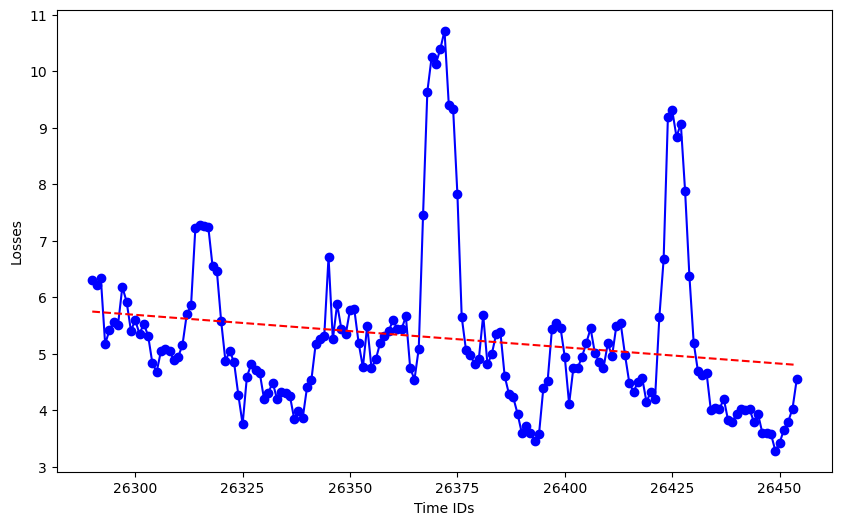

In [117]:
time_ids_x = list(loss_per_time_id_dict.keys())
losses_y = list(loss_per_time_id_dict.values())

plt.figure(figsize = (10, 6))
plt.plot(time_ids_x, losses_y, marker='o', linestyle='-', color='b')

plt.xlabel('Time IDs')
plt.ylabel('Losses')

trendline_coeffs = np.polyfit(time_ids_x, losses_y, 1)
trendline = np.polyval(trendline_coeffs, time_ids_x)

plt.plot(time_ids_x, trendline, color='r', linestyle='--', label='Trendline')

plt.show()

##### 9.2) Observations & Conclusions
- The losses are trending downwards as time progresses. This is <i>contradictory</i> to what was expected.<br>
  <br>
  The reason is as follows: -<br>
  The test data consists of test IDs ranging from 26290 to 26454.
  The prediction for 26290 (for example) is based on lagged target values which are known since they originate from the training data.
  For example, the sequence based on which the target for a particular stock would have been predicted for time ID 26290 would consist of the target    values for the following time IDs: -<br>
  26283, 26285, 26286, 26287, 26288, 26289<br>
  These target values for these time IDs for all stock IDs lie in the training data and are, therefore, known.<br>
  Therefore, it was expected that the prediction for time ID 26290 and the time IDs that immediately follow would be highly accurate.<br>
  <br>
  However, the prediction for time ID 26350 for all stocks would be based on the target values associated with the following time IDs in the
  sequence: -<br>
  26343, 26345, 26346, 26347, 26348, 26349<br>
  The target values associated with the above time IDs are NOT known and are predicted. This means that the target prediction for time ID 26350 will
  be based on target prediction (and NOT known target values) for time IDs in the above sequence.<br>
  Therefore, it was expected that the prediction for time ID 26350 and other time IDs that come later would exhibit high degree of inaccuracy.<br>
  <br>
- The model could potentially be improved by:-<br>
  - Incorporating additional features in the inputs to the training model.<br>
  - Experimenting with different values of CORR_THRESHOLD (Correlation Threshhold) based on which the lag values to be included in the input sequence are selected.<br>